In [1]:
import os
import shutil
import pandas as pd
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from torchvision.datasets import ImageFolder
import random
import torch
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
target_root = "celeba_balanced_4class"

In [3]:
selected_attrs = ['Black_Hair', 'Blond_Hair', 'Gray_Hair', 'Wearing_Hat']

In [4]:
for attr in selected_attrs:
    src_dir = os.path.join(source_root, attr)
    dst_dir = os.path.join(target_root, attr)
    os.makedirs(dst_dir, exist_ok=True)

    # Select N images randomly
    img_files = os.listdir(src_dir)
    selected_imgs = random.sample(img_files, samples_per_class)

    for img in selected_imgs:
        shutil.copyfile(os.path.join(src_dir, img), os.path.join(dst_dir, img))

In [5]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.CenterCrop(178),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

dataset = ImageFolder(target_root, transform=transform)

total = len(dataset)
train_size = int(0.8 * total)
val_size = int(0.1 * total)
test_size = total - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=4)

In [6]:
import torchvision.models as models
import torch.nn as nn

model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, 4)  # 4 classes
model = model.cuda()

In [7]:
def evaluate(model, loader):
    model.eval()
    correct, total, val_loss = 0, 0, 0.0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.cuda(), y.cuda()
            logits = model(x)
            val_loss += F.cross_entropy(logits, y).item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total, val_loss / len(loader)

def train(model, train_loader, val_loader, epochs=10, save_path="mobilenetv2_celeba_balanced.pth"):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    best_val_acc = 0.0
    for epoch in range(epochs):
        model.train()
        for x, y in train_loader:
            x, y = x.cuda(), y.cuda()
            logits = model(x)
            loss = F.cross_entropy(logits, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        val_acc, val_loss = evaluate(model, val_loader)
        print(f"Epoch {epoch+1}: Val Acc = {val_acc:.4f}, Val Loss = {val_loss:.4f}")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)
            print(f"✅ Best model saved to {save_path}")
        return model 

In [8]:
final_model = train(model, train_loader, val_loader, epochs=10)

Epoch 1: Val Acc = 0.9626, Val Loss = 0.1140
✅ Best model saved to mobilenetv2_celeba_balanced.pth


In [9]:
save_path = 'final_model_celebA_mobilenet.pth'
torch.save(final_model.state_dict(), save_path)

# Evaluation and saving

In [10]:
import torch
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from collections import defaultdict

In [12]:
import torchvision.models as models
import torch.nn as nn

model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, 4)  # 4 classes

model.load_state_dict(torch.load("final_model_celebA_mobilenet.pth"))
model.eval().cuda()

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [13]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import torch

def evaluate_test(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()
            logits = model(x)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=class_names)
    cm = confusion_matrix(all_labels, all_preds)

    print(f"✅ Test Accuracy: {acc:.4f}")
    print("\n📋 Classification Report:\n", report)
    print("\n📊 Confusion Matrix:\n", cm)

# Usage
evaluate_test(model, test_loader, selected_attrs)

✅ Test Accuracy: 0.9666

📋 Classification Report:
               precision    recall  f1-score   support

  Black_Hair       0.97      0.98      0.97      1446
  Blond_Hair       0.98      0.98      0.98      1046
   Gray_Hair       0.94      0.95      0.94       414
 Wearing_Hat       0.96      0.93      0.94       596

    accuracy                           0.97      3502
   macro avg       0.96      0.96      0.96      3502
weighted avg       0.97      0.97      0.97      3502


📊 Confusion Matrix:
 [[1411    3   17   15]
 [   3 1029    9    5]
 [   3   12  393    6]
 [  38    6    0  552]]


/tmp/ipykernel_535179/1436263665.py:35: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/home/db1702/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


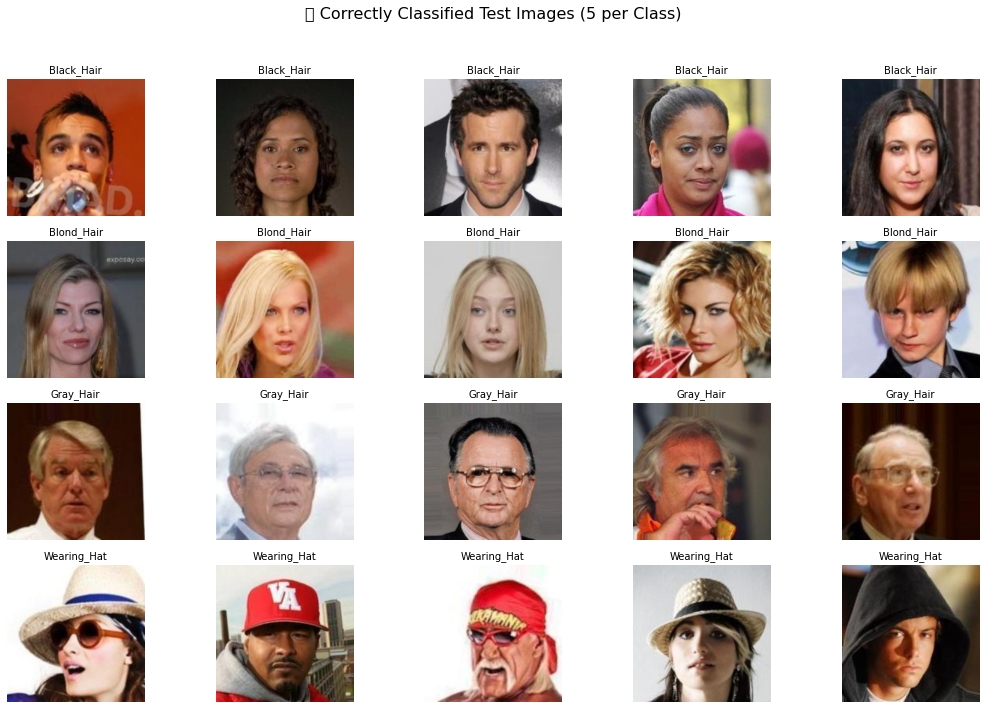

In [14]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from collections import defaultdict

def plot_correct_predictions_per_class(model, test_loader, class_names, max_per_class=5):
    model.eval()
    correct_by_class = defaultdict(list)

    with torch.no_grad():
        for x, y in test_loader:
            x = x.cuda()
            y = y.cuda()
            logits = model(x)
            preds = torch.argmax(logits, dim=1)

            for i in range(x.size(0)):
                true = y[i].item()
                pred = preds[i].item()
                if true == pred and len(correct_by_class[true]) < max_per_class:
                    correct_by_class[true].append(x[i].cpu())

            if all(len(correct_by_class[c]) >= max_per_class for c in range(len(class_names))):
                break

    # Plotting
    plt.figure(figsize=(15, 10))
    for class_idx, class_name in enumerate(class_names):
        for j in range(max_per_class):
            img = TF.to_pil_image((correct_by_class[class_idx][j] * 0.5 + 0.5))  # De-normalize
            plt.subplot(len(class_names), max_per_class, class_idx * max_per_class + j + 1)
            plt.imshow(img)
            plt.title(f"{class_name}", fontsize=10)
            plt.axis('off')
    plt.suptitle("✅ Correctly Classified Test Images (5 per Class)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Usage
plot_correct_predictions_per_class(model, test_loader, selected_attrs, max_per_class=5)